In [110]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight


In [111]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('./train'):
  train_class = os.listdir(os.path.join('train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))

retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df


Number of train images : 3662 



Image Labels
0      train/Mild/2d7666b8884f.png   Mild
1      train/Mild/50840c36f0b4.png   Mild
2      train/Mild/30cab14951ac.png   Mild
3      train/Mild/a8582e346df0.png   Mild
4      train/Mild/cab3dfa7962d.png   Mild
...                            ...    ...
3657  train/No_DR/6b30767595d8.png  No_DR
3658  train/No_DR/2b4c7b5f1f1e.png  No_DR
3659  train/No_DR/ab78a66dee6a.png  No_DR
3660  train/No_DR/79ade634c633.png  No_DR
3661  train/No_DR/7a77c3eb468c.png  No_DR

[3662 rows x 2 columns]

In [112]:
retina_df = shuffle(retina_df)

# Split the shuffled data into training and testing sets (80% train, 20% test)
train, test = train_test_split(retina_df, test_size=0.2, random_state=42)

# Update your ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range=0.2,
    vertical_flip=True,
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale = 1./255)

# Use this updated generator to load data
train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)


Found 2490 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [113]:
from keras.regularizers import l2
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

/Users/avanaku/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [114]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

checkpoint = ModelCheckpoint("model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Train the model using the generators
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10


/Users/avanaku/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.4452 - loss: 2.4155
Epoch 1: val_loss improved from inf to 1.19862, saving model to model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 798ms/step - accuracy: 0.4462 - loss: 2.4071 - val_accuracy: 0.6811 - val_loss: 1.1986
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.6566 - loss: 1.1659
Epoch 2: val_loss improved from 1.19862 to 1.00145, saving model to model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 74s 927ms/step - accuracy: 0.6567 - loss: 1.1653 - val_accuracy: 0.7107 - val_loss: 1.0014
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.6753 - loss: 1.0221
Epoch 3: val_loss improved from 1.00145 to 0.98384, saving model to model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 68s 849ms/step - accuracy: 0.6754 - loss: 1.0221 - val_accuracy: 0.7267 - val_loss: 0.9838
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.7002 - loss: 0.9868
Epoch 4: val_loss improved from 0.98384 to 0.94441, saving model to model.ker

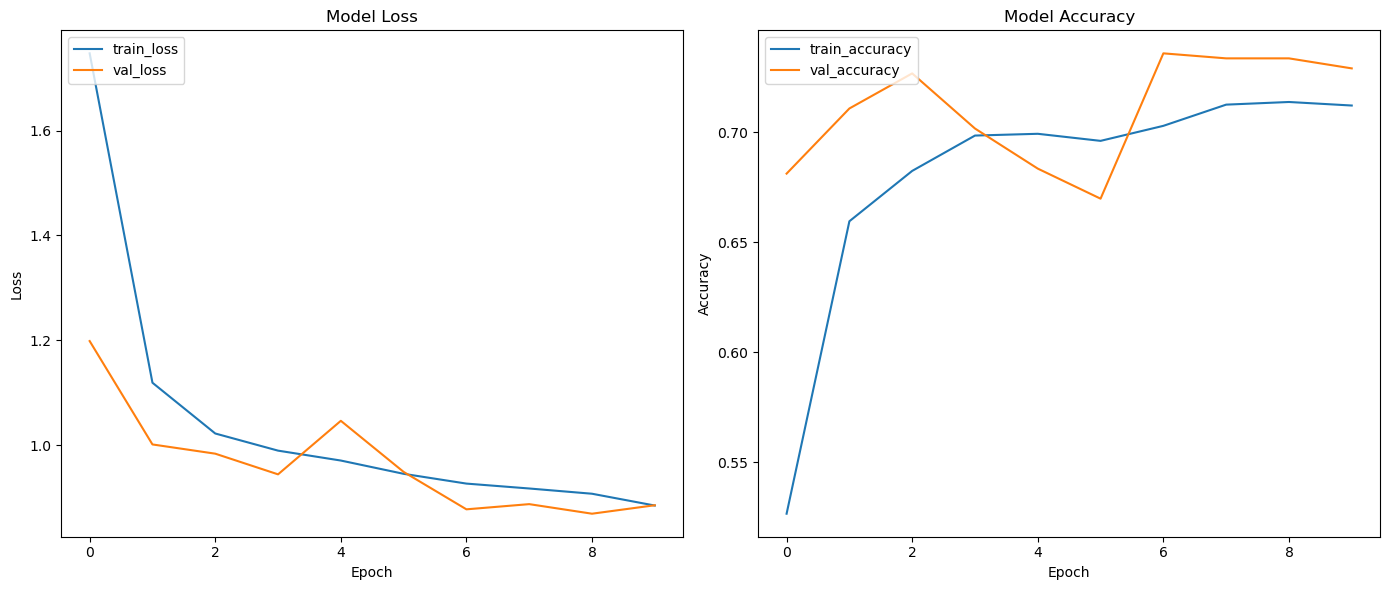

In [115]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting model loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['train_loss', 'val_loss'], loc='upper left')

# Plotting model accuracy
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

plt.tight_layout()
plt.show()


In [74]:
model.load_weights("retina_weights.hdf5")

In [89]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.7247 - loss: 0.7953
Accuracy Test : 0.7329545617103577


In [90]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}

In [91]:
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

In [92]:
# Getting the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.7366984993178718


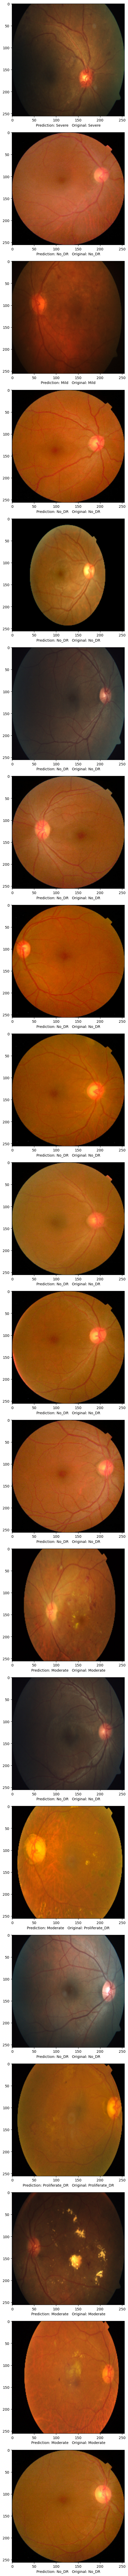

In [81]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [93]:
# Print out the classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))


                precision    recall  f1-score   support

          Mild       0.49      0.64      0.56        81
      Moderate       0.61      0.66      0.63       189
         No_DR       0.91      0.96      0.93       361
Proliferate_DR       0.46      0.26      0.33        65
        Severe       0.12      0.03      0.04        37

      accuracy                           0.74       733
     macro avg       0.52      0.51      0.50       733
  weighted avg       0.71      0.74      0.72       733

